Requirements

In [ ]:
import cv2
import numpy as np
from skimage.color import rgb2gray
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import os
from scipy.ndimage import convolve


Loading Image [Priyansh Trivedi]

In [ ]:
img_path = "/content/f_r_1340_.jpg"
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB) / 255.0

White Balance Correction [Aditi Agarwal]

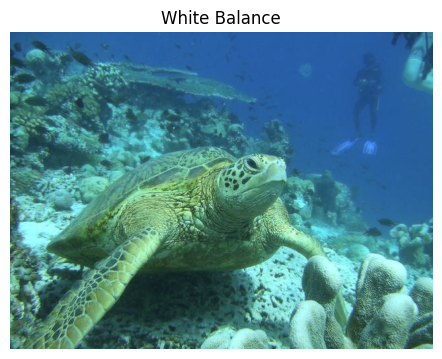

In [ ]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

r_mean, g_mean, b_mean = r.mean(), g.mean(), b.mean()

alpha = 1
r_mod = r + alpha * (g_mean - r_mean) * (1 - r) * g     #Adjusting red channel from green channel
alpha = 0.5
b_mod = b + alpha * (g_mean - b_mean) * (1 - b) * g     #Adjusting blue channel from green channel

comp_img = np.stack([r_mod, g, b_mod], axis=-1)         #Stacking RGB images on each other

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(comp_img)
plt.title("White Balance")
plt.axis("off")
plt.show()

Adjusting Gamma [Aditi Agarwal]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def gamma_adjust(img, gamma):
    img = img / 255.0              #Scaling intensity levels from 0 to 1
    img = np.power(img, gamma)     #Applying gamma correction
    return np.uint8(img * 255)     #Scaling intensities back from 0 to 255


gamma = 2
img_gamma = gamma_adjust(comp_img, gamma)

Histogram Equalisation [Aashi Jain]

In [ ]:
def hist_eq(image):

    # Getting different Intensities values from image
    intensity_values, counts = np.unique(image.flatten(), return_counts=True)
    total_pixels = image.size
    pr = counts / total_pixels

    # Calculating Cummulative Distribution Function
    cdf = np.cumsum(pr)

    L = 256

    # Mapping Intensities values
    T_r = np.round((L - 1) * cdf).astype(np.uint8)

    # Lookup table for Intensity transformation
    lookup_table = np.zeros(L, dtype=np.uint8)
    lookup_table[intensity_values] = T_r

    # FInal Equalised Image
    equalized_image = lookup_table[image]

    return equalized_image

Gaussian Blur Function [Rizul Gupta]

In [ ]:
# below function generates a 1D Gaussian kernel based on the given sigma value, size of the kernel is calculated
# to be 6 times sigma (plus one to make it odd) to ensure a sufficiently large support for the kernel
# kernel values are calculated using Gaussian function and then normalized to ensure that sum of the kernel equals 1.

def Gaussian_1d_kernel(sigma):
    ksize = int(6 * sigma + 1)
    kernel = np.zeros(ksize)
    center = ksize // 2

    for x in range(ksize):
        kernel[x] = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - center) ** 2) / (2 * sigma ** 2))

    kernel /= kernel.sum()
    return kernel

# below function applies a 2D Gaussian blur to an image. It constructs a 2D Gaussian kernel by taking the outer product of generated 1D kernel with itself
# image is then convolved with the resulting 2D Gaussian kernel to apply the blur

def DIPgaussbluur(img, sigma):
    gaus1d = Gaussian_1d_kernel(sigma)
    size = len(gaus1d)

    gaus2d = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            gaus2d[i, j] = gaus1d[i] * gaus1d[j]

    img2 = cv2.filter2D(img, -1, gaus2d)
    return img2


Unsharp Masking [Aashi Jain]

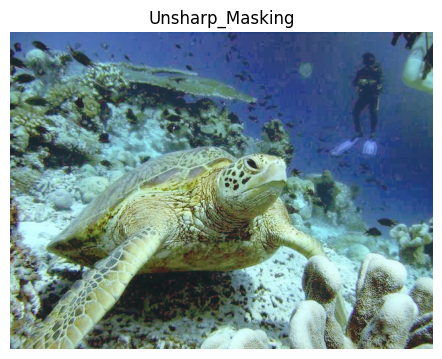

In [ ]:
# Performing Unsharp Masking on a single channel
def unsharp_masking(channel, size, sigma, amt, thresh):

    # Blurring image using Gaussian Blur
    blurred =  DIPgaussbluur(channel,sigma)
    sharp = cv2.addWeighted(channel, 1.0 + amt, blurred, -amt, 0)

    # Applying threshold to avoid low contrast
    if thresh > 0:
        low_contrast = np.absolute(channel - blurred) < thresh
        np.copyto(sharp, channel, where=low_contrast)
    return sharp

# Perfoming Unsharp Masking on all three channel (RGB)
def unsharp_mask_color(img, size=(5, 5), sigma=1.0, amt=1.5, thresh=0):

    # Spliting and Applying Unsharp Masking on RGB separately
    b, g, r = cv2.split(img)
    b = unsharp_masking(b, size, sigma, amt, thresh)
    g = unsharp_masking(g, size, sigma, amt, thresh)
    r = unsharp_masking(r, size, sigma, amt, thresh)

    # Merging and returning the Unsharped image
    return cv2.merge([b, g, r])

# Parameters for Gaussian Smoothing
sigma = 20
count = 30

# Making copy of White Balanced Image
smoothed = comp_img.copy()

# Iteratively Smoothing the image to compute base layer
for _ in range(count):
    smoothed =DIPgaussbluur(smoothed,sigma)
    smoothed = np.minimum(comp_img, smoothed)

# Computing Mask
g_mask = (comp_img - smoothed)

# Equalising histogram for each channel in g_mask
for ch in range(3):
    g_mask[:, :, ch] = hist_eq((g_mask[:, :, ch] * 255).astype(np.uint8)) / 255.0

# Combining the Equalised g_mask and White Balanced Image
sharp_img = (comp_img + g_mask) / 2

# Plotting the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(sharp_img)
plt.title("Unsharp_Masking")
plt.axis("off")
plt.show()

Weight Map Generation [Rizul Gupta]

In [ ]:
# edge_map function generates edge weight map of image by convolving Laplacian kernel which highlights edges by calculating the second-order derivatives of the image.
#resulting edge map is then squared to account for negative values using square root and squaring operations.

def edge_map(img):
    laplacian_kernel = np.array([[0,  1,  0],
                                 [1, -4,  1],
                                 [0,  1,  0]])
    gray_img = np.mean(img, axis=2)
    lap_edges = convolve(gray_img, laplacian_kernel, mode='reflect')
    return np.sqrt(np.square(lap_edges))

# sat_map function calculates saturation weight map of image based on the deviation of each pixel's color from its luminance
# which is a grayscale representation of the image based on human visual sensitivity to RGB channels.

def sat_map(img):
    luminance = 0.2126 * img[:, :, 0] + 0.7152 * img[:, :, 1] + 0.0722 * img[:, :, 2]
    luminance = np.expand_dims(luminance, axis=2)  # expand to match image dimensions
    dev = np.square(img - luminance)
    return np.sqrt(np.mean(dev, axis=2) * (1/3))

# the below function combines edge and saturation weight maps of both sharpened and gamma-corrected images
# to calculate the final weight maps by normalizing them and avoiding division by zero through the use of an offset.

def calc_weights(sharp_edge_wmap, sharp_sat_wmap, gamma_edge_wmap, gamma_sat_wmap, offset=0.1):
    num_sharp_wmap = sharp_edge_wmap + sharp_sat_wmap + offset
    num_gamma_wmap = gamma_edge_wmap + gamma_sat_wmap + offset
    denom = num_sharp_wmap + num_gamma_wmap
    return num_sharp_wmap / denom, num_gamma_wmap / denom

sharp_edge_wmap = edge_map(sharp_img)
sharp_sat_wmap = sat_map(sharp_img)
gamma_edge_wmap = edge_map(img_gamma)
gamma_sat_wmap = sat_map(img_gamma)

# calculates the final weight maps for both images by calling the 'calc_weights' function.
sharp_wmap, gamma_wmap = calc_weights(sharp_edge_wmap, sharp_sat_wmap, gamma_edge_wmap, gamma_sat_wmap)


Gaussian and Laplacian Pyramid Generation [Priyansh Trivedi]

In [ ]:
def gaussian_pyr(img, level):
	# first define a 1d gauss kernel and multiply it with its transpose to generate 2d kernel
  #now fill the gaussain pyr array with the first element as the original image and consequent entries are blurred and downsampled version of the previous image
  gaus1d = np.array([1/16, 4/16, 6/16, 4/16, 1/16], dtype=np.float32)
  sz = len(gaus1d)
  gaus2d = np.zeros((sz, sz), dtype=np.float32)
  for i in range(sz):
      for j in range(sz):
          gaus2d[i, j] = gaus1d[i] * gaus1d[j]
  pyr = [img]
  current_img = img.copy()
  for i in range(level):
      img2 = np.zeros(current_img.shape, dtype=np.float32)
      img2 = cv2.filter2D(current_img,-1,gaus2d)
      img2 = img2[0::2, 0::2]
      pyr.append(img2)
      current_img = img2

  return pyr
def laplacian_pyr(img, levels):
    #get the gaussain pyramid array
    # and fill the empty laplacian pyr array with difference of the ith and upsampled i+1th level image of gaussain pyr
    #at last append the last level of the gaussian pyramid
    pyr = gaussian_pyr(img, levels)
    lap = []
    for i in range(levels):
        currimg=pyr[i]
        smallerimg=pyr[i+1]
        new_width = currimg.shape[1]
        new_height = currimg.shape[0]
        target_size = (new_width, new_height)
        smallerimg=cv2.resize(smallerimg,dsize=target_size)
        img3=currimg-smallerimg
        lap.append(img3)
    lap.append(pyr[levels])

    return lap


levels = 5
#gaussain pyramids for the wwightmaps are generated using the above function
gsharp_pyr = gaussian_pyr(sharp_wmap, levels)
ggamma_pyr = gaussian_pyr(gamma_wmap, levels)
ref_shape = (gsharp_pyr[0].shape[1], gsharp_pyr[0].shape[0])

lap_channels_1 = []
lap_channels_2 = []
#for each channel i.e. r g b laplacian pyramid is generated for both sharpened and gamma corrrectd images
for ch in range(3):
    lap_channels_1.append(laplacian_pyr(sharp_img[:, :, ch], levels))
    lap_channels_2.append(laplacian_pyr(img_gamma[:, :, ch], levels))

lsharp_r, lsharp_g, lsharp_b = lap_channels_1
lgamma_r, lgamma_g, lgamma_b = lap_channels_2

Resizing and Weighted Combination [Aditi Agarwal]

In [ ]:
def resize_and_weight(level, gsharp_pyr, ggamma_pyr, sharp_r, sharp_g, sharp_b, gamma_r, gamma_g, gamma_b,
                      ref_shape):
    rr, rg, rb = [], [], []
    for k in range(level+1):

        #Weighted combination for resizing in RGB channel respectively

        rr.append(gsharp_pyr[k]*sharp_r[k]+ggamma_pyr[k]*gamma_r[k])
        rg.append(gsharp_pyr[k]*sharp_g[k]+ggamma_pyr[k]*gamma_g[k])
        rb.append(gsharp_pyr[k]*sharp_b[k]+ggamma_pyr[k]*gamma_b[k])

    return rr, rg, rb

rr, rg, rb = resize_and_weight(levels, gsharp_pyr, ggamma_pyr, lsharp_r, lsharp_g, lsharp_b, lgamma_r, lgamma_g,
                                   lgamma_b, ref_shape)

Pyramid Rconstruction [Rizul Gupta]

In [ ]:
# reconstruct_pyramid function reconstructs image pyramid by successively resizing the images in the pyramid and adding
# them to the next higher resolution level. reconstruction is done starting from the smallest resolution
# and going up to the original image resolution, returning the final reconstructed image

def reconstruct_pyramid(pyr):
    img = pyr[-1]
    for i in range(len(pyr) - 2, -1, -1):
        size = (pyr[i].shape[1], pyr[i].shape[0])
        img = cv2.resize(img, size)
        pyr[i] = cv2.add(img, pyr[i])
        img = pyr[i]
    return pyr[0]

# reconstructs each channel's image pyramid

channels = [rr, rg, rb]
recon_channels = [reconstruct_pyramid(channel) for channel in channels]


Final Image After Reconstruction and plotting image [Priyansh Trivedi]

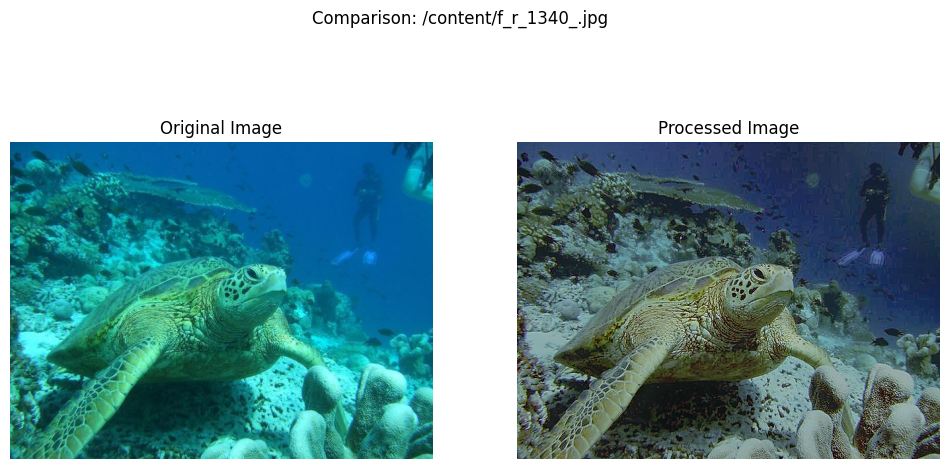

In [ ]:
fusion = np.stack(recon_channels, axis=-1)

fusion_sharp = unsharp_mask_color(fusion * 255.0)

final_image = fusion_sharp / 255.0

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title("Processed Image")
plt.axis("off")
plt.suptitle(f"Comparison: {img_path}")
plt.show()


Plotting all the images after each Step

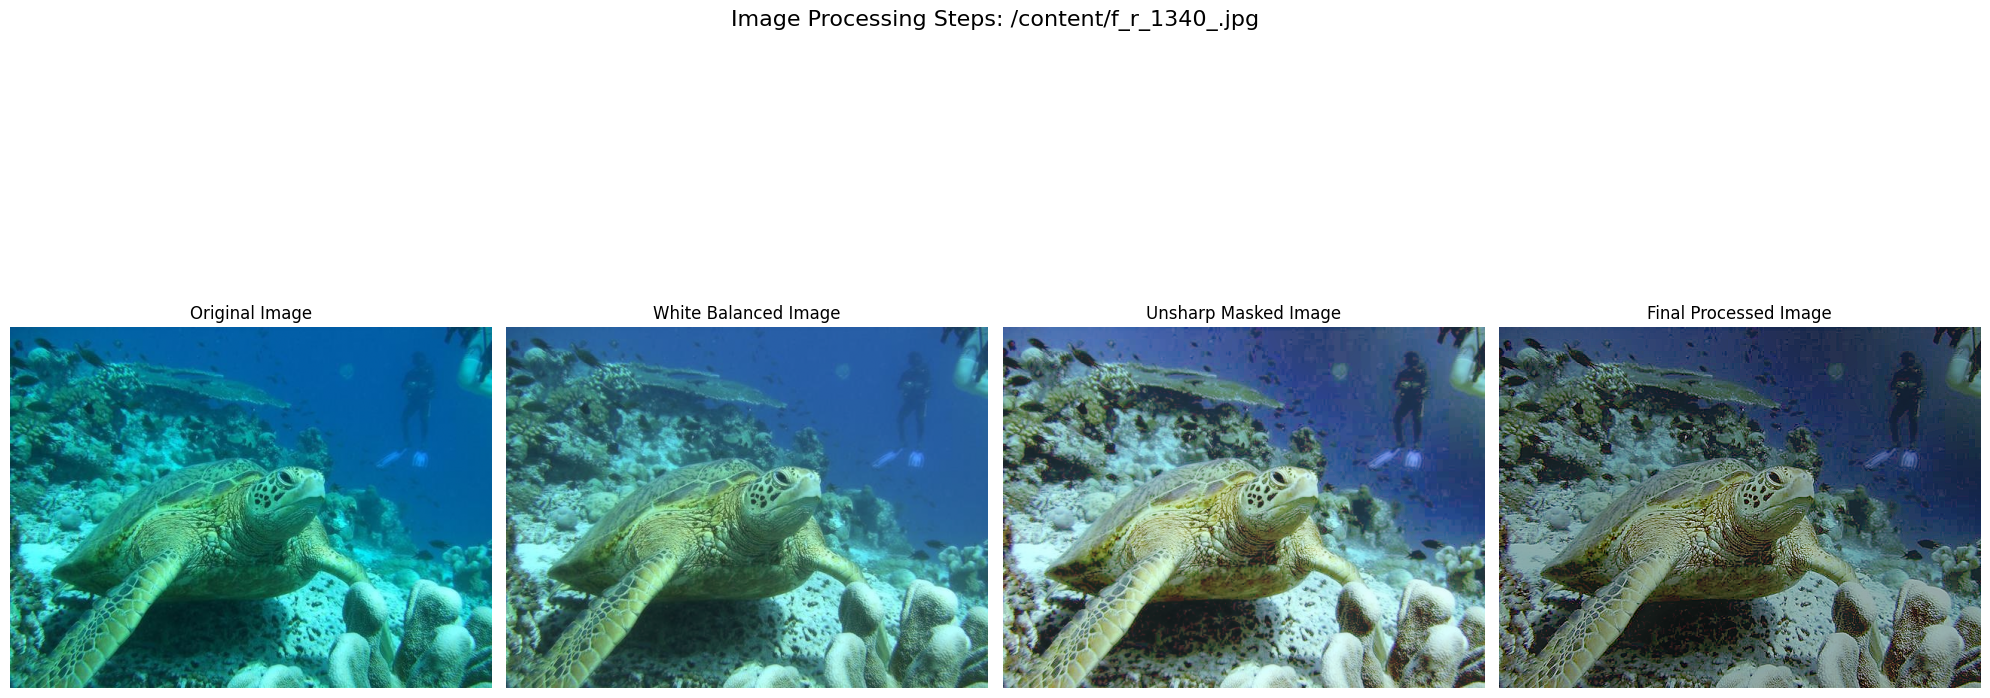

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(comp_img)
plt.title("White Balanced Image")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(sharp_img)
plt.title("Unsharp Masked Image")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(final_image)
plt.title("Final Processed Image")
plt.axis("off")

plt.suptitle(f"Image Processing Steps: {img_path}", fontsize=16)
plt.tight_layout()
plt.show()
